In [ ]:
#import freud, mdtraj
#import MDAnalysis as mda
import numpy as np
from scipy.spatial import cKDTree, Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import networkx as nx
from matplotlib.collections import LineCollection
import numpy as np
from scipy.spatial import cKDTree, Delaunay
from itertools import combinations

a = 1.42
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 12,
})

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [ ]:
import numpy as np
from scipy.spatial import cKDTree, Delaunay
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def find_dynamic_cutoff(positions, factor=1.2):
    dists, _ = cKDTree(positions).query(positions, k=4)
    bond_len = np.median(dists[:, 3])
    return factor * bond_len

def NN(positions, factor=1.2):
    tri = Delaunay(positions)
    N = len(positions)

    # collect unique undirected edges from the Delaunay triangles
    delaunay_edges = set()
    for simplex in tri.simplices:
        for (i, j) in combinations(simplex, 2):
            if i < j:
                delaunay_edges.add((i, j))
            else:
                delaunay_edges.add((j, i))

    # compute the “typical bond length” cutoff
    R = find_dynamic_cutoff(positions, factor=factor)

    # keep only those edges whose length < R
    edges_kept = []
    for (i, j) in delaunay_edges:
        d_ij = np.linalg.norm(positions[i] - positions[j])
        if d_ij < R:
            edges_kept.append((i, j))

    # build symmetric adjacency
    neigh = [[] for _ in range(N)]
    for (i, j) in edges_kept:
        neigh[i].append(j)
        neigh[j].append(i)

    return neigh


def theta_ij(xi, yi, xj, yj):
    dx = xj - xi
    dy = yj - yi
    return np.arctan2(dy, dx)

def find_rings(adjacency, max_cycle_size=8):

    N = len(adjacency)
    found_rings = set()

    def dfs(start, current_path, visited_set):
        if len(current_path) > max_cycle_size:
            return
        current = current_path[-1]
        for nbr in adjacency[current]:
            if nbr == start and len(current_path) >= 3:
                ring = frozenset(current_path)
                found_rings.add(ring)
            elif nbr not in visited_set:
                dfs(start, current_path + [nbr], visited_set | {nbr})

    for i in range(N):
        dfs(i, [i], {i})
    return found_rings

def reorder_ring(ring_nodes, positions, adjacency):

    ring_nodes = set(ring_nodes)
    sub_adj = {i: [j for j in adjacency[i] if j in ring_nodes] for i in ring_nodes}

    start = next(iter(ring_nodes))
    order = [start]
    prev = None
    cur = start

    for _ in range(len(ring_nodes) - 1):
        nxt = [j for j in sub_adj[cur] if j != prev and j not in order]
        if not nxt:
            # fallback: sort by angular coordinate around centroid
            cen = positions[list(ring_nodes)].mean(axis=0)
            return sorted(ring_nodes,
                          key=lambda i: np.arctan2(positions[i, 1] - cen[1],
                                                   positions[i, 0] - cen[0]))
        prev, cur = cur, nxt[0]
        order.append(cur)

    return order

def plot_defects(positions, neighbor_list, area, fname="picture"):

    N = len(positions)
    edges = [(i, j) for i in range(N) for j in neighbor_list[i] if j > i]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(positions[:, 0], positions[:, 1], s=20, c='k', alpha=1)
    ax.axis('equal')
    ax.set_yticks([])
    ax.set_xticks([])

    # draw each bond exactly once
    segs = [(positions[i], positions[j]) for i, j in edges]
    ax.add_collection(LineCollection(segs, colors='k', linewidths=1.5, zorder=1))

    # highlight non-hexagonal rings
    for ring in find_rings(neighbor_list, max_cycle_size=8):
        if len(ring) == 6:
            continue  # skip perfect hexagons
        ordered = reorder_ring(ring, positions, neighbor_list)
        coords = positions[ordered + [ordered[0]]]
        col, lw = ('k', 3) if len(ring) in (5, 7, 8) else ('k', 2)
        ax.plot(coords[:, 0], coords[:, 1], '-', color=col, linewidth=lw, zorder=3)

    ax.set_xlim(area[0], area[1])
    ax.set_ylim(area[2], area[3])
    plt.savefig(f'../output/defects/{fname}.png', bbox_inches='tight', dpi=200)
    plt.show()


In [ ]:

def theta_ij(xi, yi, xj, yj):
    dx = xj - xi
    dy = yj - yi
    return np.arctan2(dy,dx)


def find_rings(adjacency, max_cycle_size=8):

    N = len(adjacency)
    found_rings = set()

    def dfs(start, current_path, visited_set):
        if len(current_path) > max_cycle_size:
            return
        current = current_path[-1]
        for nbr in adjacency[current]:
            if nbr == start and len(current_path) >= 3:
        
                ring = frozenset(current_path)
                found_rings.add(ring)
            elif nbr not in visited_set:
                dfs(start, current_path + [nbr], visited_set | {nbr})

    for i in range(N):
        dfs(i, [i], {i})
    return found_rings

def reorder_ring(ring_nodes, positions, adjacency):
    """
    Return ring nodes in cyclic order.
    - First try a bond-by-bond walk through the sub-graph.
    - If the walk dead-ends (branch or missing bond), fall back to
      sorting the nodes by polar angle around the ring centroid.
    """
    ring_nodes = set(ring_nodes)
    # adjacency restricted to this ring
    sub_adj = {i: [j for j in adjacency[i] if j in ring_nodes] for i in ring_nodes}

    start  = next(iter(ring_nodes))
    order  = [start]
    prev   = None
    cur    = start

    for _ in range(len(ring_nodes) - 1):
        nxt = [j for j in sub_adj[cur] if j != prev and j not in order]
        if not nxt:                          # branch / gap ⇒ use geometric fallback
            cen = positions[list(ring_nodes)].mean(axis=0)
            return sorted(ring_nodes,
                          key=lambda i: np.arctan2(positions[i,1]-cen[1],
                                                   positions[i,0]-cen[0]))
        prev, cur = cur, nxt[0]
        order.append(cur)

    return order

def plot_defects(positions,neighbor_list, area, fname="picture"):

    N = len(positions)
    edges = [(i, j) for i in range(N) for j in neighbor_list[i] if j > i]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(positions[:, 0], positions[:, 1], s=20, c='k', alpha=1)
    ax.axis('equal')
    ax.set_yticks([])
    ax.set_xticks([])
    # — draw every bond once —
    segs = [(positions[i], positions[j]) for i, j in edges]
    ax.add_collection(LineCollection(segs, colors='k', linewidths=1.5, zorder=1))

    # — highlight non-hexagonal rings only —
    for ring in find_rings(neighbor_list, max_cycle_size=8):
        if len(ring) == 6:
            continue                                           # skip perfect hexagons
        ordered = reorder_ring(ring, positions, neighbor_list)
        coords  = positions[ordered + [ordered[0]]]
        col, lw = ('k', 4) if len(ring) in (5, 7, 8) else ('k', 3)
        ax.plot(coords[:, 0], coords[:, 1], '-', color=col, linewidth=lw, zorder=3)

    ax.set_xlim(area[0],area[1])
    ax.set_ylim(area[2],area[3])

    plt.savefig(f'../output/defects/{fname}.png', bbox_inches='tight', dpi=200)
    plt.show()

# Flower

In [ ]:
T = 9669
a = 1.42

data = np.loadtxt(f"../output/GAMMAS/{T}/min_{T}K.data",skiprows=15)
pos = data[:,2:4] / a 
neighs = NN(pos)

area = [40, 50, 22, 33]

plot_defects(pos,neighs, area, fname ="flower")

# Haeckelite

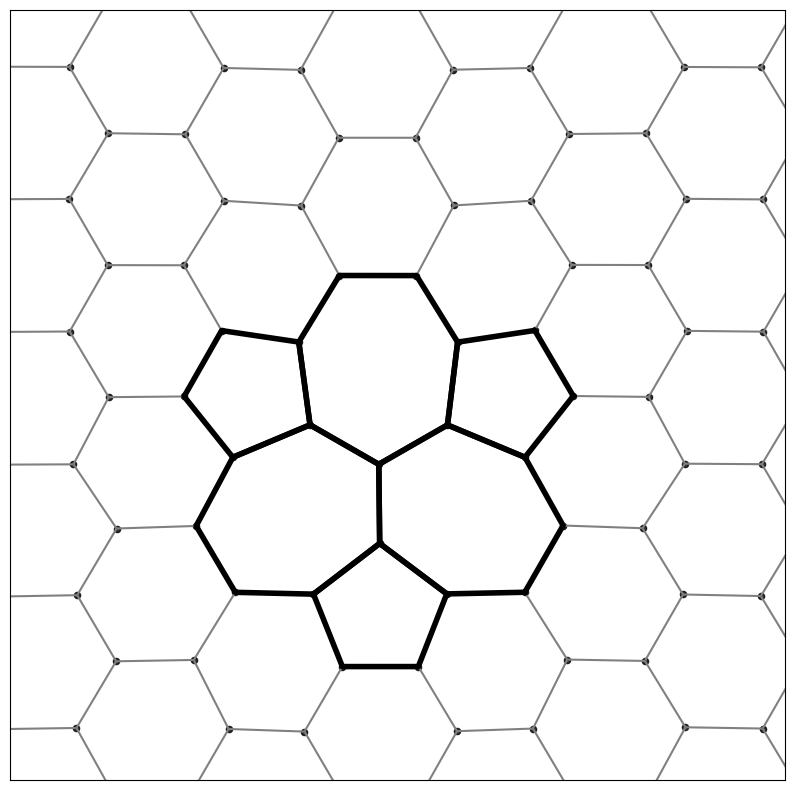

In [3]:
T = 9769
a = 1.42

data = np.loadtxt(f"../output/GAMMAS/{T}/min_{T}K.data",skiprows=15)
pos = data[:,2:4] / a 
neighs = NN(pos)

area = [8, 16, 50, 60]

plot_defects(pos,neighs, area, fname =f"haeckelite")

# (1,0) dislocation

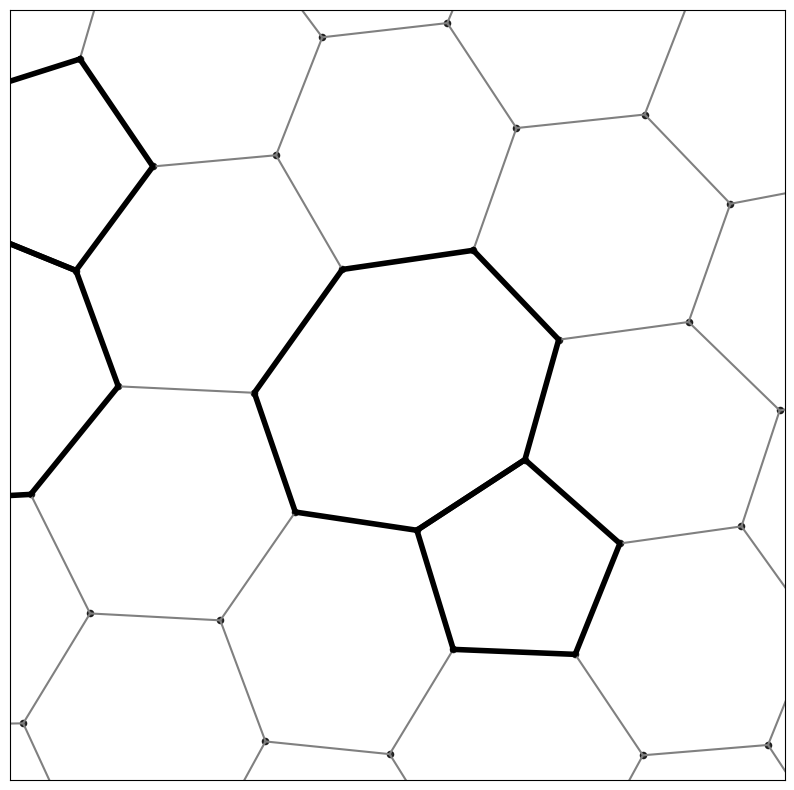

In [17]:
area = [113, 119, 86, 92]

T = 9640
a = 1.42

data = np.loadtxt(f"../output/GAMMAS/{T}/anneal_{T}K.data",skiprows=15)
pos = data[:,2:4] / a 
neighs = NN(pos)

plot_defects(pos,neighs, area, fname =f"10-dislocation")

# LAGB (GRAIN BOUDNARY) II

In [ ]:
T = 9750
a = 1.42

data = np.loadtxt(f"../output/GAMMAS/{T}/anneal_{T}K.data",skiprows=15)
pos = data[:,2:4] / a 
neighs = NN(pos)

area = [1, 17.5, 102.5, 118]

plot_defects(pos,neighs, area, fname ="LAGB_II")

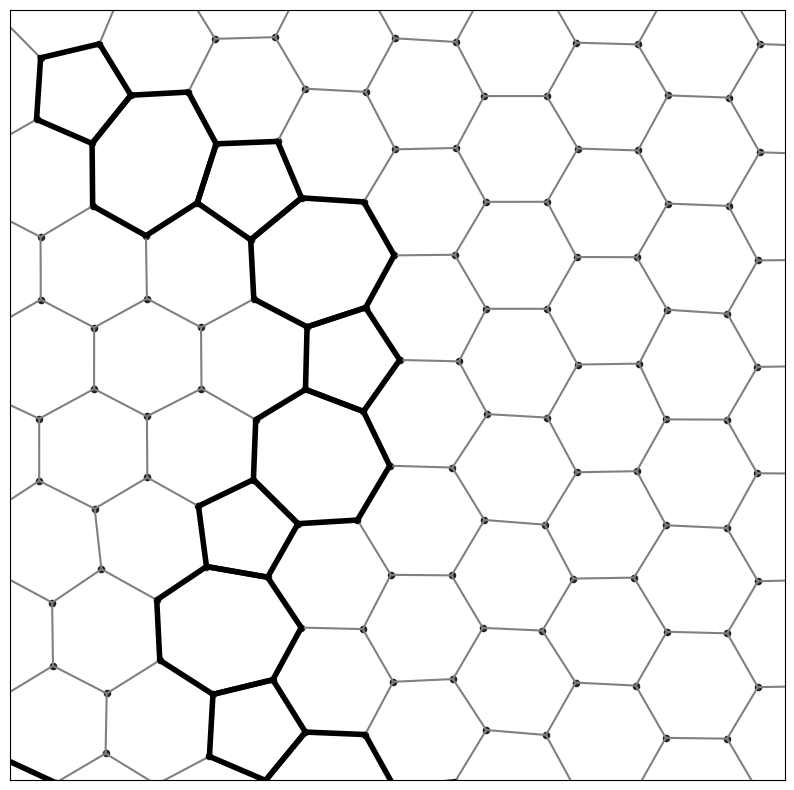

In [13]:
area = [7.5, 7.5+12.5, 75, 75+12.5]

T = 9640
a = 1.42

data = np.loadtxt(f"../output/GAMMAS/{T}/anneal_{T}K.data",skiprows=15)
pos = data[:,2:4] / a 
neighs = NN(pos)


plot_defects(pos,neighs, area, fname =f"LAGB")

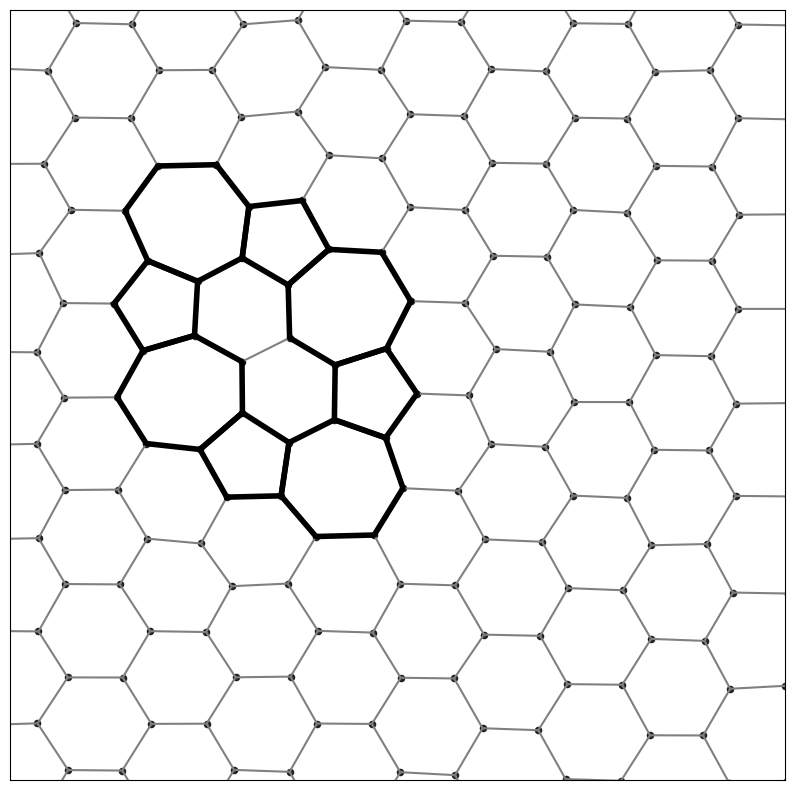

In [8]:
area = [2, 22, 2, 22]

T = 9785
a = 1.42

data = np.loadtxt(f"../output/GAMMAS/{T}/anneal_{T}K.data",skiprows=15)
pos = data[:,2:4]
neighs = NN(pos)


plot_defects(pos,neighs, area, fname =f"vacancies")

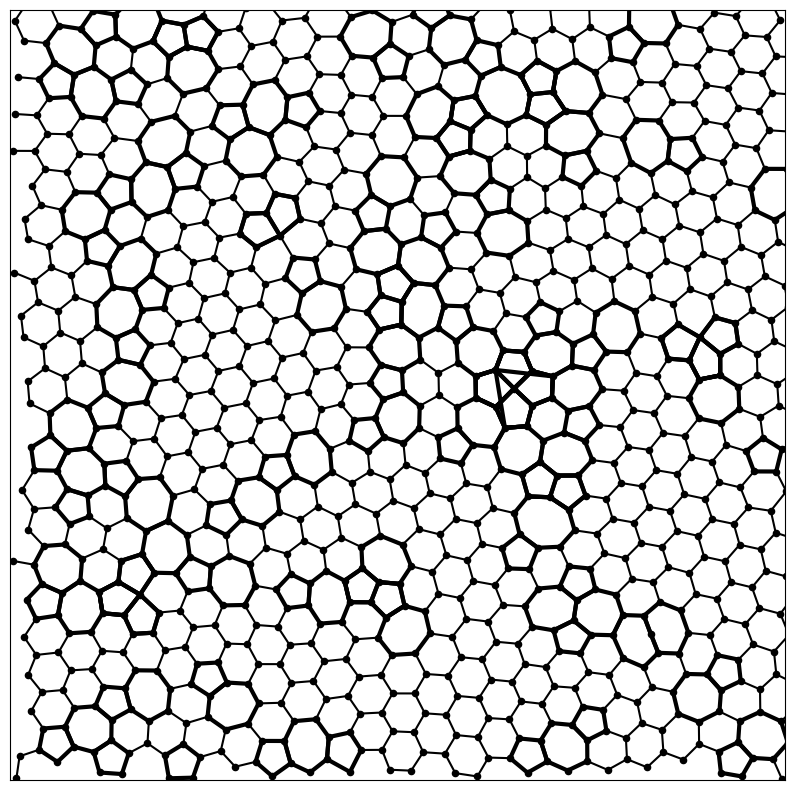

In [63]:
area = [0, 50, 0, 50]
pos = np.loadtxt("data/MAC_model.txt")[:,2:4]
neighs = NN(pos)
idx = 1000
plot_defects(pos, neighs, area, fname =f"MAC_model")

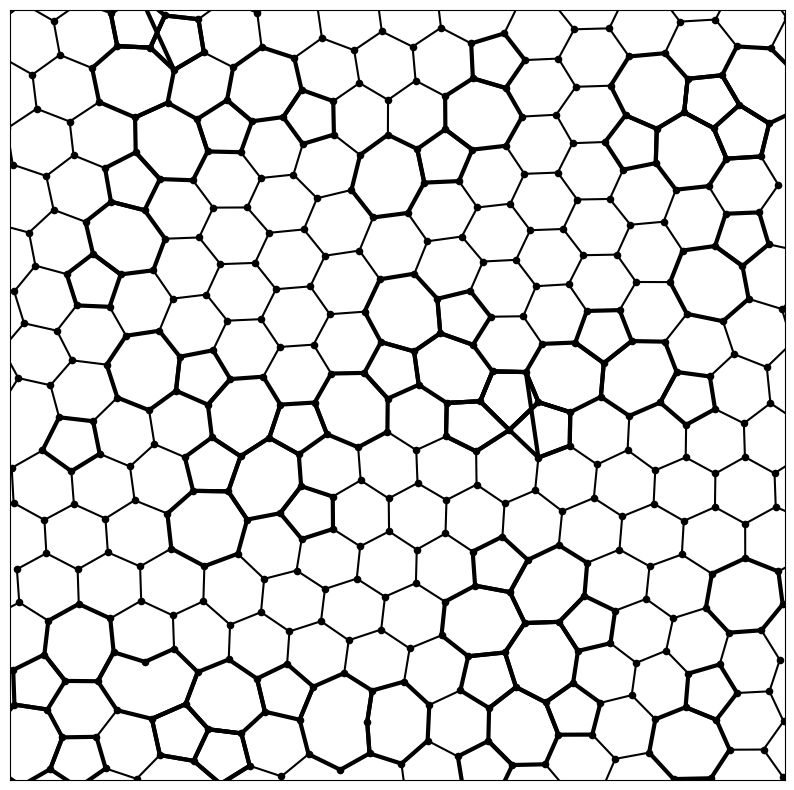

In [70]:
pos = np.loadtxt("data/MAC_model2.txt")[:,2:4]
area = [1, pos[:,0].max()-1, 1, pos[:,1].max()-1]

neighs = NN(pos)
idx = 1000
plot_defects(pos, neighs, area, fname =f"MAC_model2")